# P1: Redes Neuronales
## Construcción de un clasificador en PyTorch

 Esta práctica consistirá en implementar una red neuronal básica utilizando PyTorch para clasificar imágenes del conjunto de datos MNIST. MNIST es un conjunto de datos clásico que contiene imágenes de dígitos escritos a mano (0-9) en escala de grises de 28x28 píxeles. El objetivo es entrenar un clasificador que pueda predecir correctamente el dígito representado en cada imagen de entrada.

## Entorno
La siguiente celda importa las bibliotecas y módulos esenciales de PyTorch y torchvision necesarios para trabajar con redes neuronales, procesar datos y entrenar modelos.

In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Datos de entrada
El primer paso consistirá en preparar el conjunto de datos MNIST para entrenamiento y test.

1. **`transform = transforms.Compose([...])`**: Define una serie de transformaciones que se aplicarán a cada imagen de MNIST.
1. **`torchvision.datasets`**: torchvision proporciona una serie de conjuntos de datos ampliamente utilizados de forma nativa, como MNIST.
1. **`DataLoader`**: esta clase permitirá iterar sobre el conjunto de datos creado anteriormente (clase Dataset) tanto en el bucle de entrenamiento como en inferencia.
  1. Los DataLoaders para entrenamiento y test no reciben necesariamente los mismos argumentos.

In [6]:

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]) # Recuerda normalizar los datos de entrada

bs = 64  # batch size

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Modelo
Empezaremos con un clasificador sencillo que consistirá en un Perceptrón Multicapa (MLP), con la siguiente arquitectura:
1. Una capa oculta con 128 neuronas de salida.
2. Una capa con las salidas de clasificación finales (logits).

Deberéis decidir las dimensiones de entrada y salida restantes teneiendo en cuenta el problema de clasificación que estamos intentando resolver en MNIST.

In [8]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Capa oculta con 128 neuronas e imagenes de 28x28 pieles, son fully conected
        self.relu = nn.ReLU() #Usamos relu de funcion de activacion, que transforma valores negativos en 0 y deja los positivos igual.
        self.fc2 = nn.Linear(128, 10)  # Capa de salida con 10 clases, podriamos aplicar softmax pero ya lo hace crossentropy y no hace falta

    def forward(self, x):
        #x contiene varias imágenes aplanadas en vectores
        #Cada imagen (vector de 784 valores) pasa por una capa completamente conectada
        #y se transforma en un nuevo vector de 128 valores por imagen
        x = x.view(-1, 28 * 28)  # Aplanar la imagen (batch_size, 784), -1 significa que el tamaño del batch se ajusta automáticamente
        x = self.fc1(x) # se pasa cada batch por la primera capa, multiplica x por la matriz de pesos y le suma el sesgo
        x = self.relu(x) #se aplica relu, por ejemplo [-2, 3, -1, 5] pasaría a [ 0, 3,  0, 5] 
        x = self.fc2(x) #Genera valores que representan la probabilidad de cada clase antes de aplicarle softmax, el indice mas alto es la prediccion
        #el vector tendria esta forma  por ejemplo [2.3, -1.5, 0.8, 3.1, 2.9, -0.2, 1.7, 0.5, 0.1, -2.1]
        return x  # Logits sin activación final (se usará CrossEntropyLoss)

model = MNISTClassifier()
print(model)    

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Inicialización
A continuación instanciaremos el modelo y el optimizador, podéis hacer varias pruebas variando el learning rate y utilizando diferentes optimizadores. El optimizador será el encargado de actualizar los pesos del modelo en cada iteración de entrenamiento minimizando la función de coste. Utilizaremos una tasa de aprendizaje constante a lo largo de todo el entrenamiento.

Pruebas con optimizadores:
  1. Utilizando descenso de gradiente estocástico:
    1. Realizar diferentes pruebas de tasa de aprendizaje.
  1. Utilizar descenso de gradiente estocástico con decaimiento de pesos y "*momentum*".
  1. Utilizar Adam como optimizador.

Debes decidir una función de coste acorde al problema que estamos tratando.

In [10]:
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss() #funcion de coste, entropia cruzada, hay que pasarle las Z solo, porque la funcion de cross entropy de pytorch ya aplica softmax

In [11]:
#Las pruebas con diferentes hiperparámetros van debajo, no es necesario ejecutar estas 4 celdas, pero se pueden ejecutar para probar
learning_rate=0.01 

In [12]:
#Opción 1
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # probar LR al menos en el rango 0.5 overfitting 0.0001

In [13]:
#Opción 2
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)


In [14]:
#Opción 3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Bucle de entrenamiento
La siguiente función proporciona el esqueleto básico de un bucle de entrenamiento en PyTorch.
Presta especial atención al funcionamiento de las siguientes secuencias:
- Forward:

      outputs = model(images)
      loss = criterion(outputs, labels)
- Backward:

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


Se deben almacenar el valor de la función de coste de entrenamiento cada 100 iteraciones. Además, después de cada época, se debe calcular el coste sobre el conjunto de validación.


In [16]:
#el loss (pérdida) de validación es la pérdida calculada sobre el conjunto de datos de validación después de cada época de entrenamiento
#las epocas son el número de veces que el modelo procesa todo el conjunto de datos de entrenamiento

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    train_losses = [] # Lista para almacenar el loss de entrenamiento en cada época
    val_losses = []   
    
    for epoch in range(epochs):
        model.train() # Poner el modelo en 'modo' entrenamiento
        running_loss = 0.0 # Acumulador para la pérdida en esta época
        
        for images, labels in train_loader:
            optimizer.zero_grad() #resetear los gradientes acumulados
            outputs = model(images) #hace el forward y obtiene predicciones
            loss = criterion(outputs, labels)
            loss.backward() #hace backpropagation para calcular gradientes
            optimizer.step() #actualizamos los pesos
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        model.eval() # Ponemos el modelo en modo evaluacion
        val_loss = 0.0
        with torch.no_grad():  #No calcular gradientes durante validación
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoca {epoch+1}/{epochs} - Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses




train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

Epoca 1/5 - Loss: 0.4039 - Validation Loss: 0.2375
Epoca 2/5 - Loss: 0.2693 - Validation Loss: 0.2850
Epoca 3/5 - Loss: 0.2518 - Validation Loss: 0.2221
Epoca 4/5 - Loss: 0.2450 - Validation Loss: 0.2381
Epoca 5/5 - Loss: 0.2385 - Validation Loss: 0.2213


In [17]:
def plot_losses(train_losses, val_losses,opti,lr): #funcion para dibujar el loss
    plt.figure(figsize=(8, 5))
    epochs = range(1, len(train_losses) + 1)  # Comienza en 1
    plt.plot(epochs,train_losses, label='Loss de entrenamiento')
    plt.plot(epochs,val_losses, label='Loss de validacion')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Gráfica de loss con opti {opti} y lr {lr}')
    plt.show()

## Sacar gráficas de loss para diferentes LR y diferentes optimizadores
Representar en una misma gráfica la evolución del coste del entrenamiento y del coste de validación calculado en cada época.

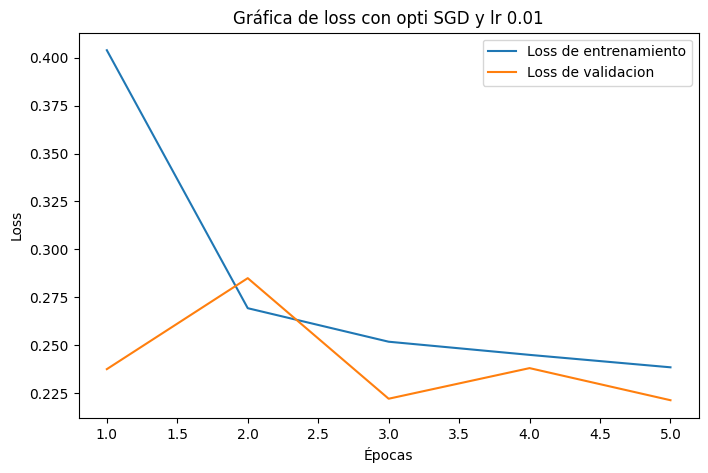

In [19]:
plot_losses(train_losses, val_losses,"SGD",learning_rate)


Entrenando con SGD y LR=0.5
Epoca 1/5 - Loss: 2.3134 - Validation Loss: 2.3024
Epoca 2/5 - Loss: 2.3030 - Validation Loss: 2.3033
Epoca 3/5 - Loss: 2.3031 - Validation Loss: 2.3026
Epoca 4/5 - Loss: 2.3031 - Validation Loss: 2.3018
Epoca 5/5 - Loss: 2.3030 - Validation Loss: 2.3034


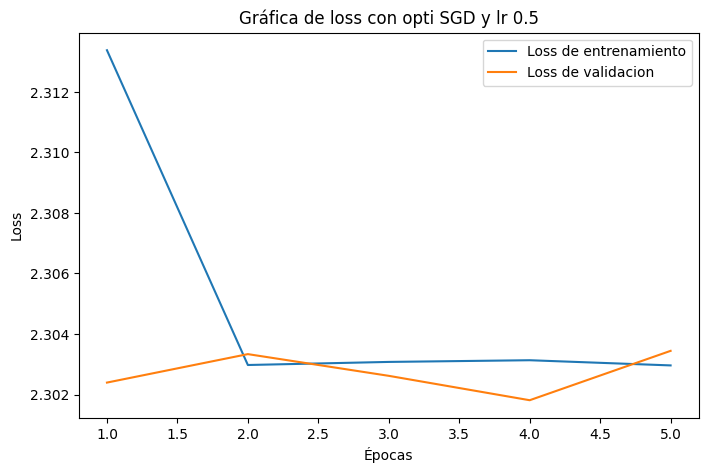


Entrenando con SGD y LR=0.1
Epoca 1/5 - Loss: 0.3934 - Validation Loss: 0.2397
Epoca 2/5 - Loss: 0.1773 - Validation Loss: 0.1952
Epoca 3/5 - Loss: 0.1319 - Validation Loss: 0.1394
Epoca 4/5 - Loss: 0.1050 - Validation Loss: 0.1070
Epoca 5/5 - Loss: 0.0915 - Validation Loss: 0.1355


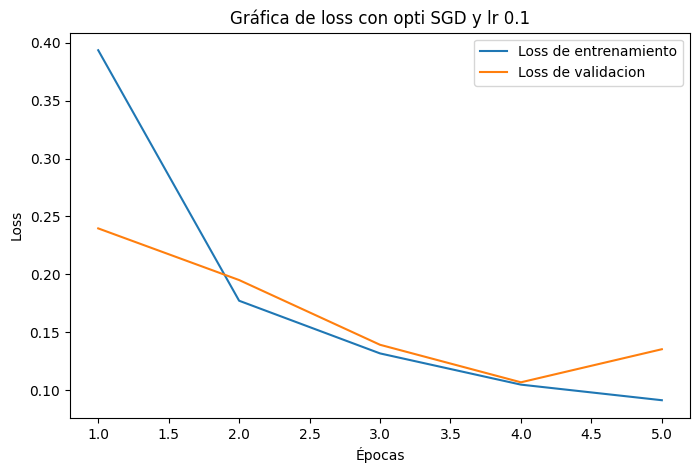


Entrenando con SGD y LR=0.01
Epoca 1/5 - Loss: 0.7533 - Validation Loss: 0.3877
Epoca 2/5 - Loss: 0.3662 - Validation Loss: 0.3178
Epoca 3/5 - Loss: 0.3213 - Validation Loss: 0.2925
Epoca 4/5 - Loss: 0.2953 - Validation Loss: 0.2807
Epoca 5/5 - Loss: 0.2746 - Validation Loss: 0.2625


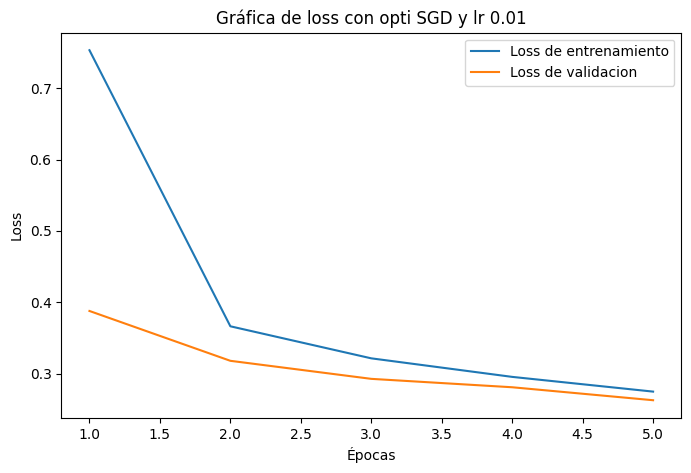


Entrenando con SGD y LR=0.001
Epoca 1/5 - Loss: 1.9071 - Validation Loss: 1.4992
Epoca 2/5 - Loss: 1.2107 - Validation Loss: 0.9496
Epoca 3/5 - Loss: 0.8347 - Validation Loss: 0.7056
Epoca 4/5 - Loss: 0.6628 - Validation Loss: 0.5852
Epoca 5/5 - Loss: 0.5703 - Validation Loss: 0.5155


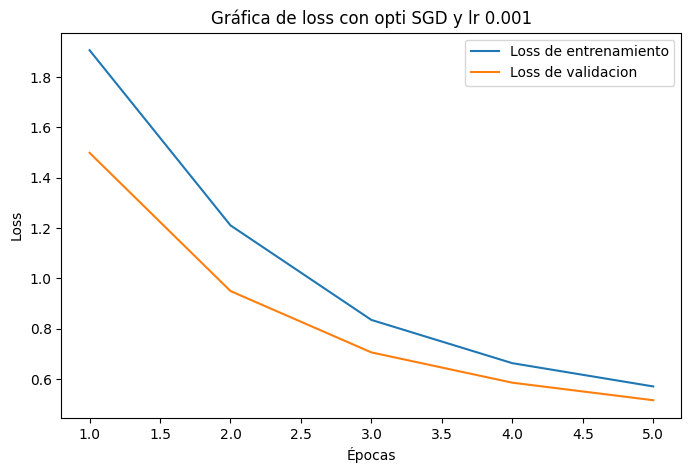


Entrenando con SGD y LR=0.0001
Epoca 1/5 - Loss: 2.2443 - Validation Loss: 2.1896
Epoca 2/5 - Loss: 2.1512 - Validation Loss: 2.1067
Epoca 3/5 - Loss: 2.0717 - Validation Loss: 2.0255
Epoca 4/5 - Loss: 1.9918 - Validation Loss: 1.9438
Epoca 5/5 - Loss: 1.9116 - Validation Loss: 1.8617


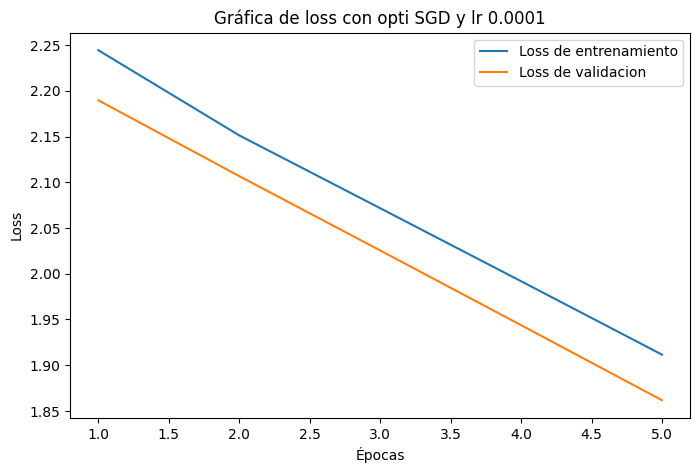


Entrenando con SGD_momentum y LR=0.5
Epoca 1/5 - Loss: 2.3530 - Validation Loss: 2.3200
Epoca 2/5 - Loss: 2.3197 - Validation Loss: 2.3367
Epoca 3/5 - Loss: 2.3200 - Validation Loss: 2.3324
Epoca 4/5 - Loss: 2.3194 - Validation Loss: 2.3268
Epoca 5/5 - Loss: 2.3204 - Validation Loss: 2.3100


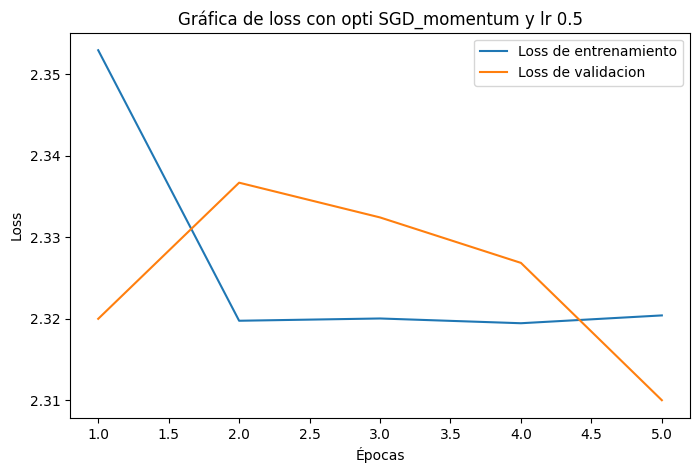


Entrenando con SGD_momentum y LR=0.1
Epoca 1/5 - Loss: 0.8256 - Validation Loss: 1.5372
Epoca 2/5 - Loss: 0.7576 - Validation Loss: 0.5815
Epoca 3/5 - Loss: 0.6719 - Validation Loss: 0.5381
Epoca 4/5 - Loss: 0.8888 - Validation Loss: 0.9483
Epoca 5/5 - Loss: 1.1329 - Validation Loss: 1.0551


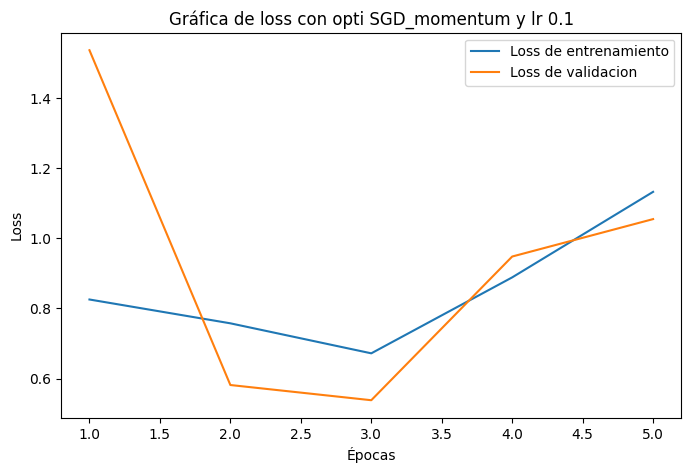


Entrenando con SGD_momentum y LR=0.01
Epoca 1/5 - Loss: 0.3751 - Validation Loss: 0.2301
Epoca 2/5 - Loss: 0.1874 - Validation Loss: 0.1479
Epoca 3/5 - Loss: 0.1363 - Validation Loss: 0.1237
Epoca 4/5 - Loss: 0.1087 - Validation Loss: 0.1167
Epoca 5/5 - Loss: 0.0941 - Validation Loss: 0.0951


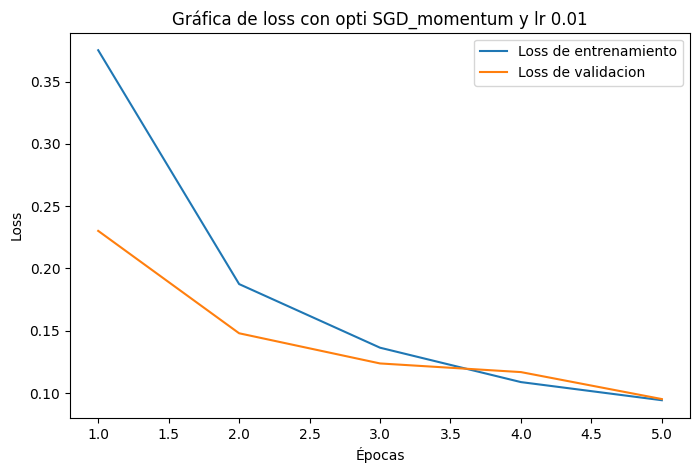


Entrenando con SGD_momentum y LR=0.001
Epoca 1/5 - Loss: 0.7812 - Validation Loss: 0.3871
Epoca 2/5 - Loss: 0.3687 - Validation Loss: 0.3218
Epoca 3/5 - Loss: 0.3252 - Validation Loss: 0.2958
Epoca 4/5 - Loss: 0.2997 - Validation Loss: 0.2812
Epoca 5/5 - Loss: 0.2794 - Validation Loss: 0.2615


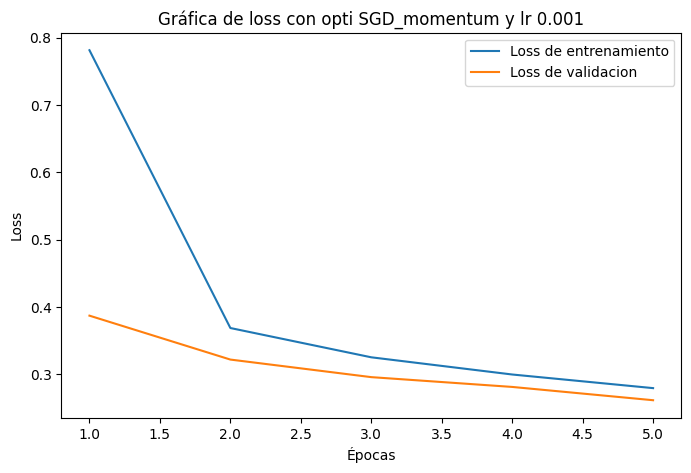


Entrenando con SGD_momentum y LR=0.0001
Epoca 1/5 - Loss: 1.9146 - Validation Loss: 1.4903
Epoca 2/5 - Loss: 1.1918 - Validation Loss: 0.9270
Epoca 3/5 - Loss: 0.8164 - Validation Loss: 0.6909
Epoca 4/5 - Loss: 0.6507 - Validation Loss: 0.5757
Epoca 5/5 - Loss: 0.5621 - Validation Loss: 0.5102


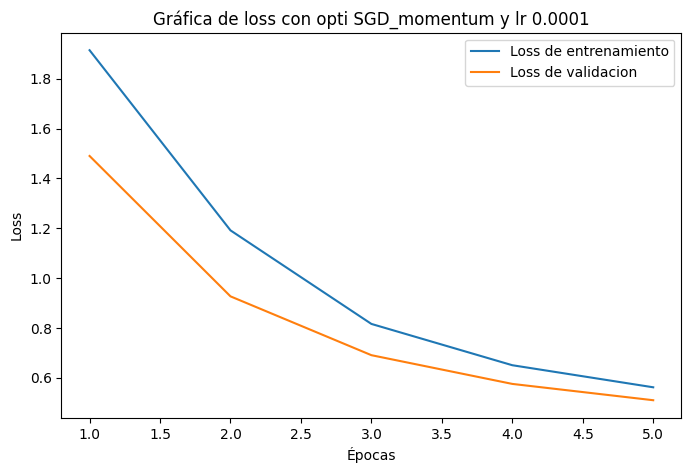


Entrenando con Adam y LR=0.5
Epoca 1/5 - Loss: 34.6733 - Validation Loss: 2.3400
Epoca 2/5 - Loss: 2.3393 - Validation Loss: 2.3398
Epoca 3/5 - Loss: 2.3415 - Validation Loss: 2.3632
Epoca 4/5 - Loss: 2.3395 - Validation Loss: 2.3810
Epoca 5/5 - Loss: 2.3398 - Validation Loss: 2.3376


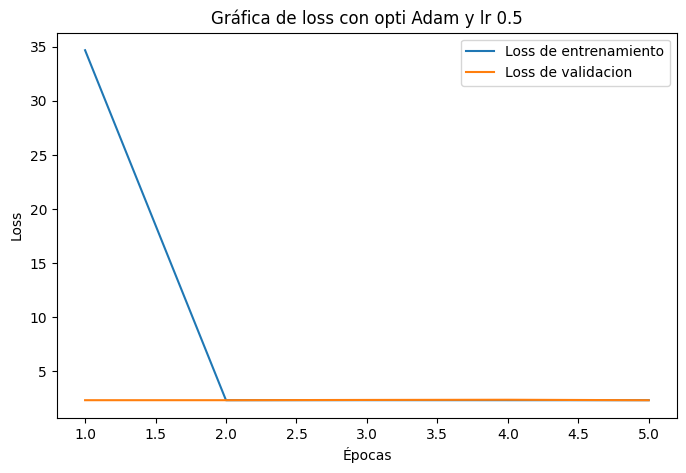


Entrenando con Adam y LR=0.1
Epoca 1/5 - Loss: 3.0390 - Validation Loss: 2.3060
Epoca 2/5 - Loss: 2.3761 - Validation Loss: 2.3072
Epoca 3/5 - Loss: 2.3098 - Validation Loss: 2.3114
Epoca 4/5 - Loss: 2.3106 - Validation Loss: 2.3055
Epoca 5/5 - Loss: 2.3106 - Validation Loss: 2.3079


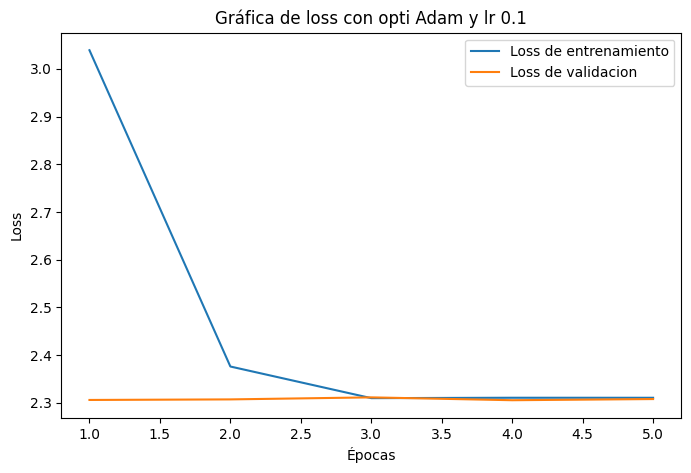


Entrenando con Adam y LR=0.01
Epoca 1/5 - Loss: 0.3749 - Validation Loss: 0.2827
Epoca 2/5 - Loss: 0.2608 - Validation Loss: 0.2298
Epoca 3/5 - Loss: 0.2361 - Validation Loss: 0.2603
Epoca 4/5 - Loss: 0.2321 - Validation Loss: 0.2258
Epoca 5/5 - Loss: 0.2268 - Validation Loss: 0.2301


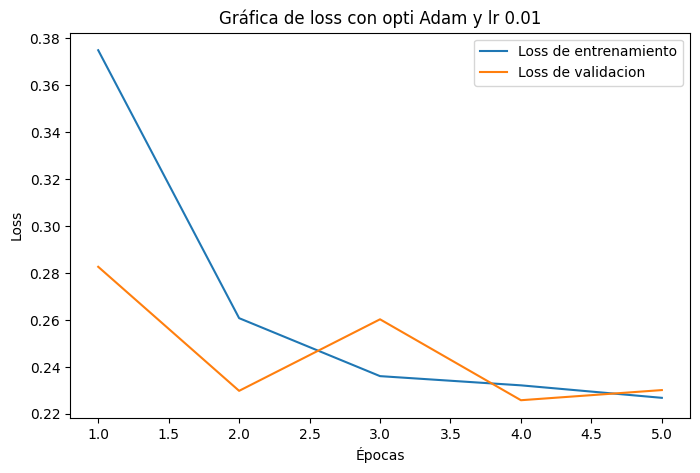


Entrenando con Adam y LR=0.001
Epoca 1/5 - Loss: 0.3817 - Validation Loss: 0.2416
Epoca 2/5 - Loss: 0.2015 - Validation Loss: 0.1516
Epoca 3/5 - Loss: 0.1431 - Validation Loss: 0.1194
Epoca 4/5 - Loss: 0.1166 - Validation Loss: 0.1345
Epoca 5/5 - Loss: 0.0987 - Validation Loss: 0.1290


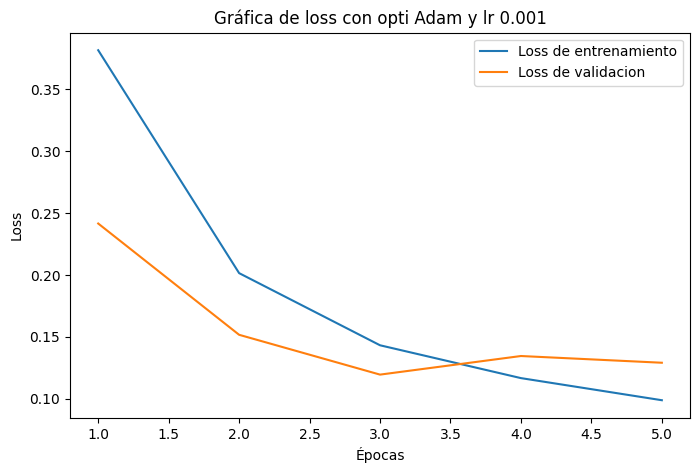


Entrenando con Adam y LR=0.0001
Epoca 1/5 - Loss: 0.7339 - Validation Loss: 0.3792
Epoca 2/5 - Loss: 0.3519 - Validation Loss: 0.3019
Epoca 3/5 - Loss: 0.2972 - Validation Loss: 0.2660
Epoca 4/5 - Loss: 0.2645 - Validation Loss: 0.2430
Epoca 5/5 - Loss: 0.2397 - Validation Loss: 0.2217


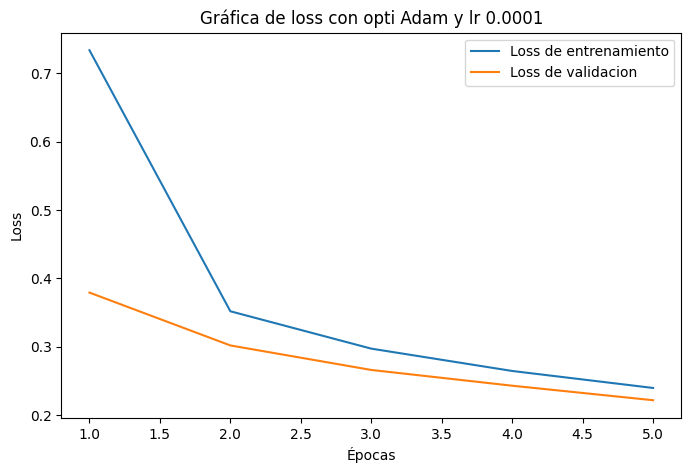

In [20]:
#Para hacer distintas pruebas con  learning rates y optimizadores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]
optimizadores = ['SGD', 'SGD_momentum', 'Adam']

#tarda un ratillo
for opti in optimizadores:
    for lr in learning_rates:
        model = MNISTClassifier().to(device)
        criterion = nn.CrossEntropyLoss()
        
        if opti == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif opti == 'SGD_momentum':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4) #dijo que tampoco probar una validacion con todos los parametros de momentum, que no hace falta
        elif opti == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        
        print(f"\nEntrenando con {opti} y LR={lr}")
        train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

        # Llamar a la función para graficar cada prueba por separado
        plot_losses(train_losses, val_losses,opti,lr)
        


## Inferencia
Función que implementa la inferencia del modelo en el conjunto de test.
Se espera un valor de Accuracy superior al 90%.

In [22]:
def evaluate_model(model, test_loader):
    model.eval()  #poner modo evaluación (desactiva dropout y batchnorm)
    correct = 0  #contador de predicciones correctas
    total = 0  #contador del total de ejemplos

    with torch.no_grad():  #no se calculan gradientes en inferencia
        for images, labels in test_loader:
            outputs = model(images) 
            _, predicted = torch.max(outputs, 1)  #obtener la clase con mayor probabilidad
            total += labels.size(0)  #sumar el total de muestras
            correct += (predicted == labels).sum().item()  #contar aciertos

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy  

evaluate_model(model, test_loader)

Test Accuracy: 93.51%


93.51

## Cálculo de loss

Vamos a calcular el loss para el primer batch del conjunto de datos de entrenamiento. Para ello recuerda convertir las etiquetas a "one hot". Una vez tengas el loss calculado comprueba que coincide con el calculado por "criterion".

En PyTorch podemos acceder a los gradientes asociados a unos pesos w a través de *w.grad*. Accede a los gradientes calculados para los pesos de la primera capa y calcula manualmente como sería el valor de los pesos tras el backward. Comprueba que los resultados calculados manualmente coinciden con los pesos una vez realizada una iteración completa de entrenamiento.

Para este ejercicio utiliza descenso de gradiente estocástico sin decaimiento de pesos ni *momentum*.

In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
model = MNISTClassifier()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Sin momentum ni weight decay
outputs = model(images)

# Calcular loss utilizando criterion
loss = criterion(outputs, labels)
print(f"Loss con criterion: {loss.item():.6f}")


# Calcular loss "manualmente"
softmax = torch.nn.functional.softmax(outputs, dim=1)  # Aplicar softmax  para obtener probabilidades de los logits
log_softmax = torch.log(softmax)  # Logaritmo de softmax
etiquetas_one_hot = torch.nn.functional.one_hot(labels, num_classes=10)  # Convertir etiquetas a one-hot
loss_manual = -(etiquetas_one_hot * log_softmax).sum(dim=1).mean()  # Cross-Entropy manual
print(f"Loss calculado manualmente: {loss_manual.item():.6f}")

loss.backward()

# Calcular como se actualizarían los pesos de la primera capa
pesos_primera_capa = model.fc1.weight
gradientes_primera_capa = pesos_primera_capa.grad
print(f"Gradientes de la primera capa:\n {gradientes_primera_capa}")

learning_rate = 0.01
nuevos_pesos = pesos_primera_capa - learning_rate * gradientes_primera_capa

# Realizar iteración de entrenamiento actualizando pesos
optimizer.step() 

print(f"Diferencia entre pesos actualizados manualmente y con optimizer:\n"
      f"{torch.norm(nuevos_pesos - model.fc1.weight).item():.6f}")

Loss con criterion: 2.319071
Loss calculado manualmente: 2.319071
Gradientes de la primera capa:
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [ 0.0058,  0.0058,  0.0058,  ...,  0.0058,  0.0058,  0.0058],
        ...,
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [-0.0052, -0.0052, -0.0052,  ..., -0.0052, -0.0052, -0.0052],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019]])
Diferencia entre pesos actualizados manualmente y con optimizer:
0.000000


## Visualización
1. Visualiza las imágenes contenidas en un batch.
1. Muestra el Ground Truth para cada una de ellas y la predicción del modelo.

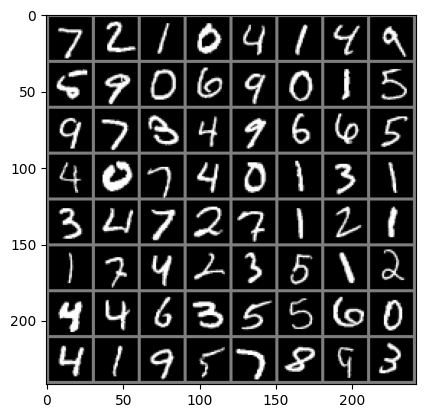

Las etiquetas de las imagenenes son:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
Las predicciones que realiza el modelo son:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9])


In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() #pasa el tensor a array de numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #En PyTorch las imágenes tienen la forma Canales, Altura, Anchura) y matplotlib las espera como (Altura, Achura, Canales)
    plt.show()

iterador = iter(test_loader) #test loader tiene una tupla con el tensor y la etiqueta por cada imagen
images, labels = next(iterador) #iteras una vez y recoges las imagenes y las etiquetas de un batch entero


imshow(torchvision.utils.make_grid(images))
print('Las etiquetas de las imagenenes son: ',labels)
outputs=model(images)
_,predicciones=torch.max(outputs, 1)
print('Las predicciones que realiza el modelo son: ',predicciones)

## Probabilidad para un ejemplo dado
1. Para cada ejemplo en el batch, además de calcular la clase predicha calcula también la probabilidad de dicha clase.

In [28]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([0.7069, 0.3835, 0.4860, 0.5288, 0.5582, 0.4234, 0.6625, 0.6793, 0.4242,
        0.4063, 0.4405, 0.5302, 0.5871, 0.5181, 0.5030, 0.6704, 0.5846, 0.8212,
        0.6622, 0.6868, 0.5546, 0.7027, 0.4991, 0.6866, 0.6363, 0.3720, 0.8227,
        0.6131, 0.6508, 0.5922, 0.7586, 0.7407, 0.7037, 0.4535, 0.4507, 0.3924,
        0.6324, 0.5830, 0.5689, 0.4314, 0.6184, 0.7008, 0.4985, 0.3048, 0.7001,
        0.8058, 0.6536, 0.3739, 0.7154, 0.4787, 0.7875, 0.6288, 0.6007, 0.8084,
        0.4295, 0.8610, 0.5424, 0.4983, 0.5380, 0.7369, 0.8715, 0.3159, 0.7619,
        0.3416], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9]))

In [29]:
import torch.nn.functional as F
# Calcular probabilidades aplicando softmax
probabilidades = F.softmax(outputs, dim=1)

# Mostrar las probabilidades del primer ejemplo del batch
for indice in range(len(images)):
    print(f"\nImagen {indice+1}")
    for i, prob in enumerate(probabilidades[indice]):
        print(f"Clase {i}: {prob.item():.4f}")


Imagen 1
Clase 0: 0.0852
Clase 1: 0.1617
Clase 2: 0.0594
Clase 3: 0.1030
Clase 4: 0.0925
Clase 5: 0.0985
Clase 6: 0.0714
Clase 7: 0.1175
Clase 8: 0.0966
Clase 9: 0.1142

Imagen 2
Clase 0: 0.0954
Clase 1: 0.1285
Clase 2: 0.0871
Clase 3: 0.1084
Clase 4: 0.0940
Clase 5: 0.1145
Clase 6: 0.0618
Clase 7: 0.1091
Clase 8: 0.0967
Clase 9: 0.1046

Imagen 3
Clase 0: 0.0882
Clase 1: 0.1386
Clase 2: 0.0826
Clase 3: 0.1082
Clase 4: 0.1028
Clase 5: 0.0960
Clase 6: 0.0721
Clase 7: 0.1161
Clase 8: 0.0847
Clase 9: 0.1107

Imagen 4
Clase 0: 0.0764
Clase 1: 0.1519
Clase 2: 0.0730
Clase 3: 0.0976
Clase 4: 0.0914
Clase 5: 0.1145
Clase 6: 0.0854
Clase 7: 0.1157
Clase 8: 0.0916
Clase 9: 0.1024

Imagen 5
Clase 0: 0.0781
Clase 1: 0.1562
Clase 2: 0.0624
Clase 3: 0.1118
Clase 4: 0.0797
Clase 5: 0.1049
Clase 6: 0.0808
Clase 7: 0.1162
Clase 8: 0.0909
Clase 9: 0.1189

Imagen 6
Clase 0: 0.0860
Clase 1: 0.1288
Clase 2: 0.0839
Clase 3: 0.1120
Clase 4: 0.1155
Clase 5: 0.0991
Clase 6: 0.0752
Clase 7: 0.1094
Clase 8: 0.0